In [44]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

In [3]:
np.random.seed(4)
m=60
w1, w2 = 0.1, 0.3
noise = 0.1
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [5]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [6]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [7]:
pca.components_.T[:,0]

array([0.93636116, 0.29854881, 0.18465208])

In [8]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [9]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [10]:
X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

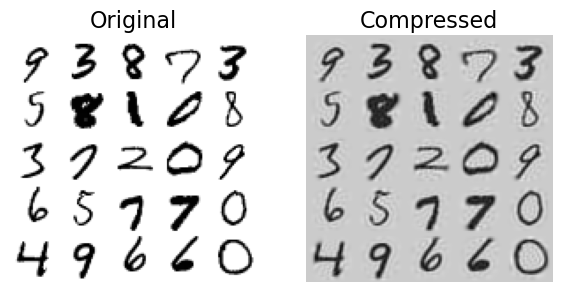

In [13]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

In [14]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

In [15]:
X_reduced = inc_pca.transform(X_train)
inc_pca.explained_variance_ratio_

array([0.09719831, 0.07155315, 0.06170874, 0.05401741, 0.04905852,
       0.04302777, 0.03278241, 0.02884626, 0.02748573, 0.02356627,
       0.02108139, 0.02040216, 0.01706003, 0.01686183, 0.01576739,
       0.0149316 , 0.01327913, 0.01284896, 0.01186785, 0.01144606,
       0.01066603, 0.01009634, 0.00958782, 0.00902642, 0.00879304,
       0.0083529 , 0.00808368, 0.00787528, 0.00741283, 0.00688457,
       0.00655717, 0.00646993, 0.00598218, 0.00585258, 0.00567315,
       0.00545248, 0.00505373, 0.00489127, 0.00480234, 0.00465976,
       0.00455173, 0.00445264, 0.00416922, 0.00397368, 0.00384205,
       0.0037527 , 0.00361843, 0.0034882 , 0.00337741, 0.00321481,
       0.00318425, 0.00308866, 0.00296756, 0.00286607, 0.00282597,
       0.00269014, 0.00267939, 0.00257067, 0.00254379, 0.00246133,
       0.00239863, 0.00236924, 0.00228793, 0.00220894, 0.00212385,
       0.0020502 , 0.0020201 , 0.00195788, 0.00192058, 0.00187533,
       0.00186343, 0.00179442, 0.00176125, 0.00173837, 0.00165

In [27]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

In [29]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)

In [31]:
X_reduced = inc_pca.fit_transform(X_train)

In [32]:
clf = Pipeline([
    ('kPCA', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])

param_grid = [{
    "kPCA__gamma": np.linspace(0.03, 0.05, 10),
    "kPCA__kernel": ["rbf", "sigmoid"]
}]

In [33]:
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kPCA', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kPCA__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kPCA__kernel': ['rbf', 'sigmoid']}])

In [36]:
grid_search.best_params_

{'kPCA__gamma': 0.043333333333333335, 'kPCA__kernel': 'rbf'}

In [38]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                   fit_inverse_transform=True)

In [40]:
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [42]:
 mean_squared_error(X, X_preimage)

32.78630879576611

In [48]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)